In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import Dict, List, Tuple

# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.grid'] = True

In [2]:
def cargar_datos(file_name : str, pow_measure = False) -> list:

    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = [np.mean(dic[offset]["V_2"])*1000 for offset in offs_values_keys]
    # Verdaderos valores de continua
    offs_true_values = [np.mean(dic[offset]["V_1"]) for offset in offs_values_keys]
    # Le sacamos la "V" a las keys
    offs_values = [float(offset[:-1]) for offset in offs_values_keys]

    # En algunas mediciones, colocamos mal inicialmente la posición del osciloscopio y se midieron mal los datos
    if corr_values[0] == -271.0:
        # Tomo el promedio de datos que estaban bien medidos
        corr_values[0] = np.mean([-331.99399999999997,-332.04800000000006,-330.99])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

# Gráficos de potencia según la corriente 

## Mediciones que tienen sentido

In [3]:
mediciones = ["Verde reflejado", "Infrarrojo transmitido", "Verde total"]
# Para guardar los datos
dic_pow = {}

for color in mediciones:
    file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia {color} 2205.pickle"

    *_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)

    # Metemos los datos en un diccionario
    dic_pow[f"corr:{color}"] = np.array(corr_values)
    dic_pow[f"pow:{color}"] = np.array(POW_values)
    dic_pow[f"sigma:{color}"] = np.array(POW_var_values)

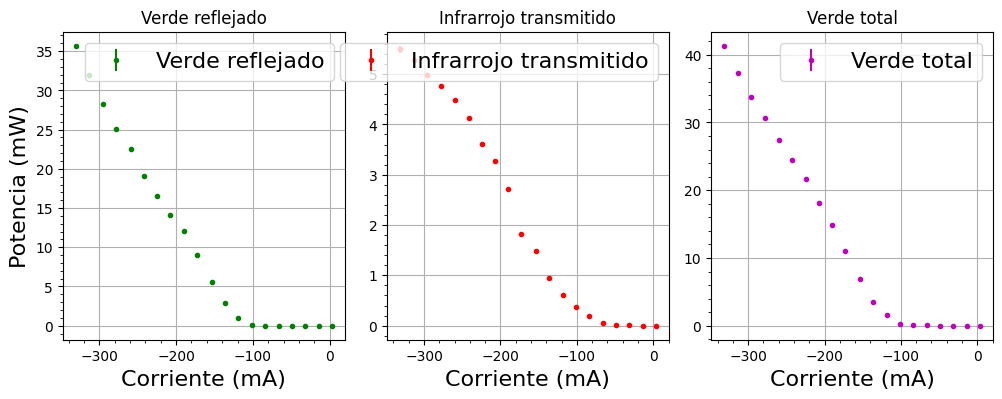

In [4]:
# Definimos listas para las labels y los colores de los graficos
labels = mediciones
marker_color = ["g","r", "m"]

fig, axs = plt.subplots(1,len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    color = mediciones[i]

    corr_values = dic_pow[f"corr:{color}"]
    POW_values = dic_pow[f"pow:{color}"] 
    POW_var_values = dic_pow[f"sigma:{color}"] 

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,fmt = ".", color = f"{marker_color[i]}", label = f"{labels[i]}")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}")
    ax.legend(loc = "upper right")

plt.subplots_adjust(wspace=0.15, hspace=0)
#plt.savefig("../imagenes/Medidor de potencia/Potencia en función de la corriente.png")
plt.show()

## Todas las mediciones

In [5]:
mediciones = ["Verde reflejado", "Verde transmitido", "Infrarrojo transmitido", "Verde total", "Infrarrojo total"]
# Para guardar los datos
dic_pow = {}

for color in mediciones:
    file_name = f"../mediciones/D.D/Medidor de potencia/Barrido para potencia {color} 2205.pickle"

    *_, corr_values, POW_values, POW_var_values = cargar_datos(file_name, pow_measure = True)

    # Metemos los datos en un diccionario
    dic_pow[f"corr:{color}"] = np.array(corr_values)
    dic_pow[f"pow:{color}"] = np.array(POW_values)
    dic_pow[f"sigma:{color}"] = np.array(POW_var_values)

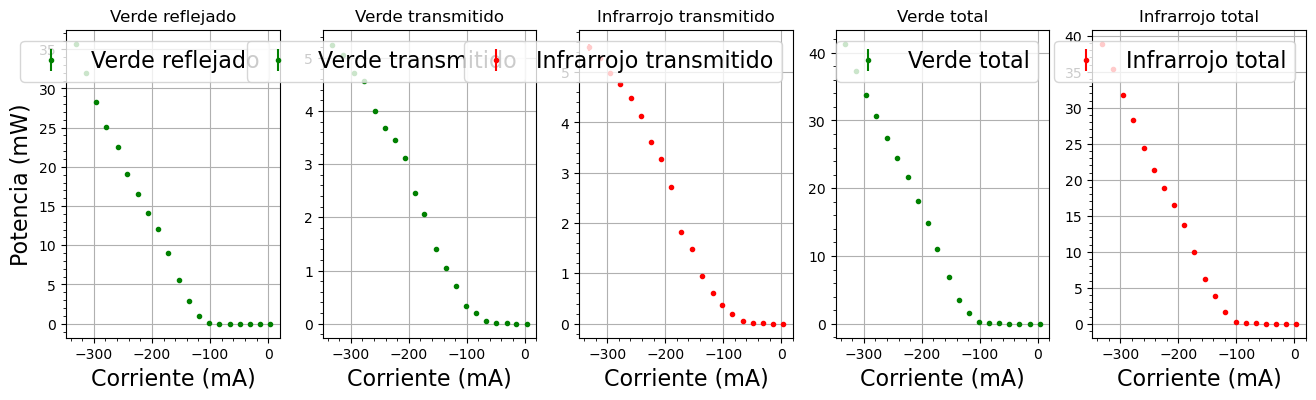

In [6]:
# Definimos listas para las labels y los colores de los graficos
labels = mediciones
marker_color = ["g","g", "r", "g", "r"]

fig, axs = plt.subplots(1,len(labels), figsize=(16,4))
for i, ax in enumerate(fig.axes):
    color = mediciones[i]

    corr_values = dic_pow[f"corr:{color}"]
    POW_values = dic_pow[f"pow:{color}"] 
    POW_var_values = dic_pow[f"sigma:{color}"] 

    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,fmt = f".{marker_color[i]}", label = f"{labels[i]}")
    ax.set_xlabel("Corriente (mA)")
    if i == 0:
        ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}")
    ax.legend(loc = "upper right")
plt.show()

# Análisis de relaciones entre las potencias

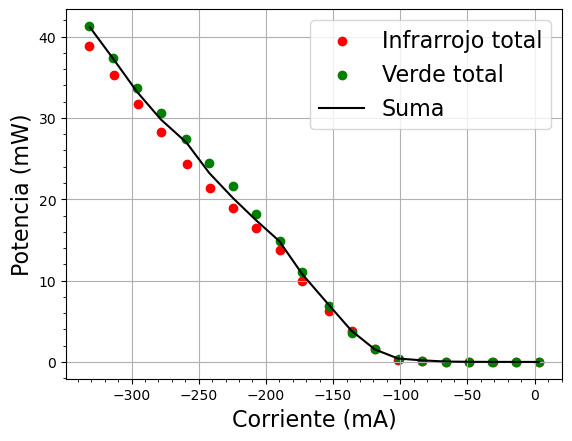

In [7]:
plt.scatter(dic_pow["corr:Infrarrojo total"],dic_pow["pow:Infrarrojo total"], label = "Infrarrojo total", color = "r")
plt.scatter(dic_pow["corr:Verde total"],dic_pow["pow:Verde total"], label = "Verde total", color = "g")

plt.plot(dic_pow["corr:Verde reflejado"], dic_pow["pow:Verde reflejado"]+dic_pow["pow:Infrarrojo transmitido"], label = "Suma", color = "k")

plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.legend()
plt.show()

In [6]:
def lineal(x, a, b): return a*np.array(x)+b

def ajuste_lineal(x: np.ndarray, y: np.array, y_err: np.ndarray) -> List[float]:

    popt, pcov = curve_fit(lineal, x,y, sigma = y_err)

    a, b = popt

    return a, b, pcov

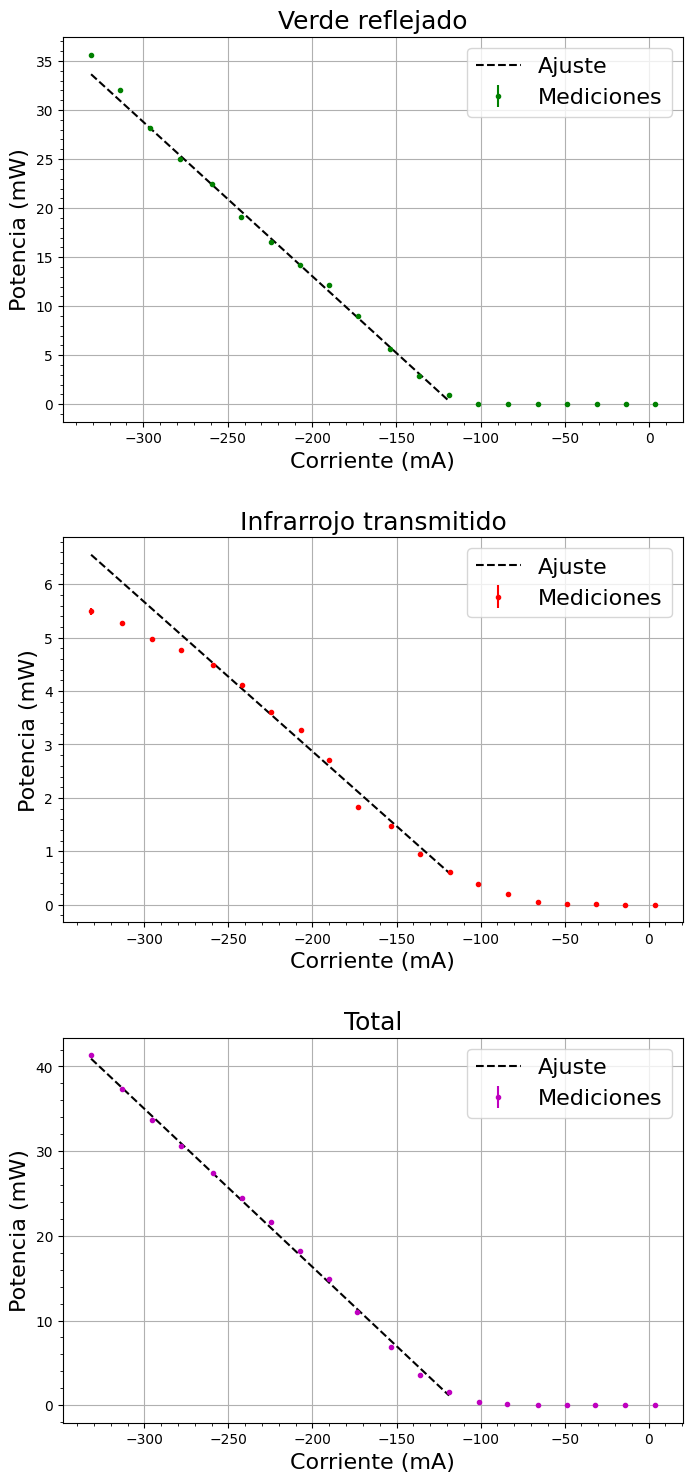

In [11]:
files = ["Verde reflejado", "Infrarrojo transmitido", "Verde total"]
labels = ["Verde reflejado", "Infrarrojo transmitido", "Total"]
marker_color = ["g","r", "m"]

lista_POW_ajuste = []

# fig, axs = plt.subplots(nrows = 1, ncols = len(files), figsize=(16,6))
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize=(8,18))
for i, ax in enumerate(fig.axes):
    
    color = files[i]

    corr_values = dic_pow[f"corr:{color}"]#[:13] 
    POW_values = dic_pow[f"pow:{color}"]#[:13] 
    POW_var_values = dic_pow[f"sigma:{color}"]#[:13] 

    a, b, cov_matrix = ajuste_lineal(corr_values[:13],POW_values[:13], POW_var_values[:13])# Ajustamos el rango en el que se prende el láser
    
    corr_ajuste = np.linspace(min(corr_values[:13]), max(corr_values[:13]), 1000)
    POW_ajuste = lineal(corr_ajuste,a,b)
    lista_POW_ajuste.append(POW_ajuste)

    # sigma = np.sqrt(cov_matrix[1,1]+(corr_ajuste**2)*cov_matrix[0,0]+2*corr_ajuste*cov_matrix[0,1])
    # y_1 = POW_ajuste+sigma
    # y_2 = POW_ajuste-sigma

    # ax.fill(
    #     np.append(corr_ajuste, corr_ajuste[::-1]),
    #     np.append(y_1, y_2[::-1]),
    #     color = marker_color[i],
    #     alpha = 0.5,
    #     label = "Bandas de error del ajuste"
    # )
 
    ax.errorbar(corr_values, POW_values,yerr = POW_var_values,marker = ".", ls = "", color = f"{marker_color[i]}", label = "Mediciones")
    ax.plot(corr_ajuste, POW_ajuste,color = "k", ls = "--", label = "Ajuste")
    ax.set_xlabel("Corriente (mA)")
    # if i == 0:
    ax.set_ylabel("Potencia (mW)")
    ax.set_title(f"{labels[i]}", fontsize = 18)
    ax.legend(loc = "upper right")
#plt.savefig("../imagenes/Medidor de potencia/Ajuste de potencia.png")
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.show()

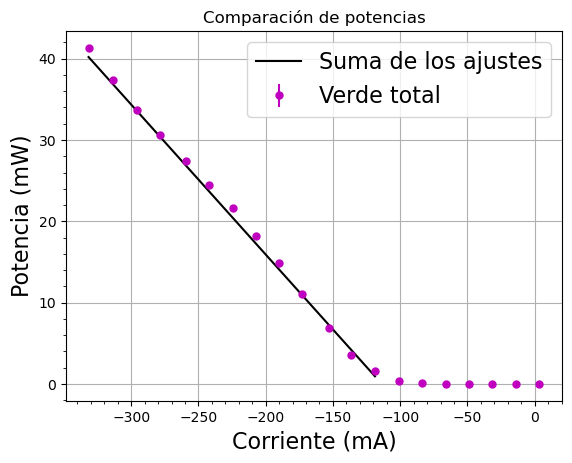

In [10]:
pow_suma = lista_POW_ajuste[0]+lista_POW_ajuste[1]

plt.plot(corr_ajuste, pow_suma, label = "Suma de los ajustes", color = "k")
#plt.scatter(dic_pow["corr:Infrarrojo total"],dic_pow["pow:Infrarrojo total"], label = "Infrarrojo total", color = "r")
plt.errorbar(dic_pow["corr:Verde total"], dic_pow["pow:Verde total"],yerr = dic_pow[f"sigma:Verde total"],marker = ".", ms = 10, ls = "", color = "m", label = "Verde total")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.title("Comparación de potencias")
plt.legend()
#plt.savefig("../imagenes/Medidor de potencia/Comparación de potencias.png")
plt.show()

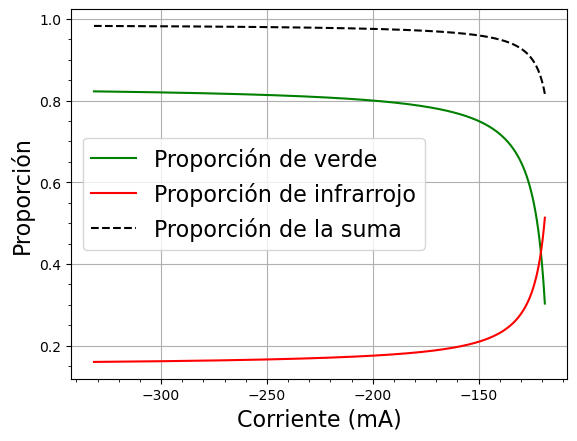

In [11]:
pow_verde, pow_rojo, pow_total = lista_POW_ajuste

plt.plot(corr_ajuste,pow_verde/pow_total, label = "Proporción de verde", color = "g")
plt.plot(corr_ajuste,pow_rojo/pow_total, label = "Proporción de infrarrojo", color = "r")
plt.plot(corr_ajuste, pow_suma/pow_total, label = "Proporción de la suma", color = "k", ls = "--")
plt.xlabel("Corriente (mA)")
plt.ylabel("Proporción")
plt.legend()
#plt.savefig("../imagenes/Medidor de potencia/Proporcion de potencia del laser.png")
plt.show()

Para calcular cuanto más grande es la potencia del verde respecto al rojo

In [12]:
corr_ajuste[148]

-300.1304691358025

In [13]:
np.mean(pow_verde[148-8:148+9]/pow_rojo[148-8:148+9])

5.0653090099779075

In [14]:
np.std(pow_verde[148-8:148+9]/pow_rojo[148-8:148+9], ddof = 1)

0.002749278933313333

In [15]:
np.mean(pow_verde/pow_rojo)

4.395734793210981

In [16]:
np.std(pow_verde/pow_rojo, ddof = 1)

0.9140061920736485

# Viejo

## Potencia de Verde+Rojo contra potencia Total

In [17]:
POW_values_suma = dic_pow["pow:rojo"]+dic_pow["pow:verde"]
POW_var_values_suma = dic_pow["sigma:rojo"]+dic_pow["sigma:verde"]

plt.errorbar(corr_values, POW_values_suma, yerr = POW_var_values_suma, fmt = ".", color = "#011627", label = "Verde+Rojo")
plt.errorbar(corr_values, dic_pow["pow:completa"],yerr = dic_pow["sigma:completa"] ,fmt = ".", color = "#FF9F1C", label = "Total")
plt.xlabel("Corriente (mA)")
plt.ylabel("Potencia (mW)")
plt.legend()
plt.show()

KeyError: 'pow:rojo'

## Diferencia relativa

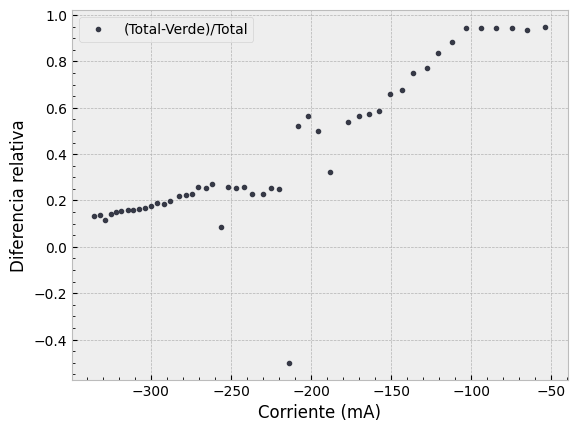

In [ ]:
POW_relativa = (dic_pow["pow:completa"]-dic_pow["pow:verde"])/dic_pow["pow:completa"]
plt.plot(corr_values, POW_relativa,".",color = "#363946", label = "(Total-Verde)/Total")
plt.legend()
plt.ylabel("Diferencia relativa")
plt.xlabel("Corriente (mA)")
plt.minorticks_on()
plt.show()

## Total-Verde

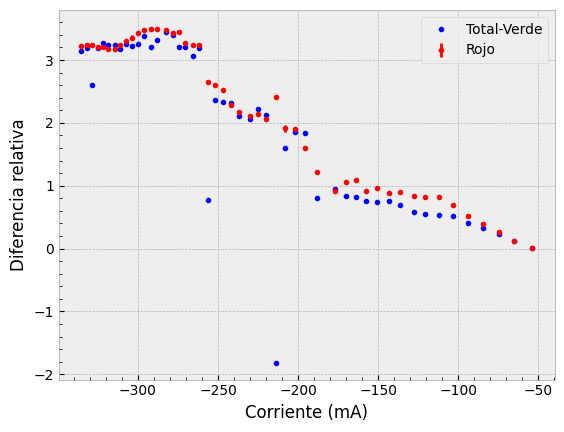

In [ ]:
POW_diff = dic_pow["pow:completa"]-dic_pow["pow:verde"]
plt.plot(corr_values, POW_diff,".b", label = "Total-Verde")
plt.errorbar(corr_values, dic_pow["pow:rojo"],yerr = dic_pow["sigma:rojo"],fmt = ".r", label = "Rojo")
plt.legend()
plt.ylabel("Diferencia relativa")
plt.xlabel("Corriente (mA)")
plt.minorticks_on()
plt.show()